<a href="https://colab.research.google.com/github/jessieDu314/JessieDu.github.io/blob/main/Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Image Data



In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username": ,"key":} 
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
!chmod 600 /content/.kaggle/kaggle.json

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v /content

In [ ]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization -p /content

In [ ]:
import zipfile
with zipfile.ZipFile("/content/landscape-image-colorization.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# Data Preprocessing

In [ ]:
import torch
from torch import Tensor
from torchvision import transforms
from PIL import Image
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import L1Loss
import torch.optim as optim
import torchvision

In [ ]:
# jpg to pkl

# color
output = []
outlier = 0
convert_tensor = transforms.ToTensor()
with open('color.pkl', "wb") as f:
  for i in range(7129):
    img = Image.open(f"/content/landscape Images/color/{i}.jpg")
    pixels = convert_tensor(img).unsqueeze(dim=0)
    if pixels.shape[2] == 150 and pixels.shape[3] == 150:
      output.append(convert_tensor(img).unsqueeze(dim=0))
    else:
      outlier += 1
  result = torch.cat(output, dim=0)
  pickle.dump(result, f)
  f.close()

# gray
output = []
outlier = 0
convert_tensor = transforms.ToTensor()
with open('gray.pkl', "wb") as f:
  for i in range(7129):
    img = Image.open(f"/content/landscape Images/gray/{i}.jpg")
    pixels = convert_tensor(img).unsqueeze(dim=0)
    if pixels.shape[2] == 150 and pixels.shape[3] == 150:
      output.append(convert_tensor(img).unsqueeze(dim=0))
    else:
      outlier += 1 #23
  result = torch.cat(output, dim=0)
  pickle.dump(result, f)
  f.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# load data
data_color = pd.read_pickle('path')
data_gray = pd.read_pickle('path')

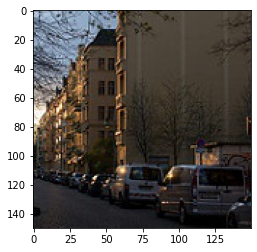

In [ ]:
plt.imshow(data_color[0].permute(1, 2, 0))
plt.show()

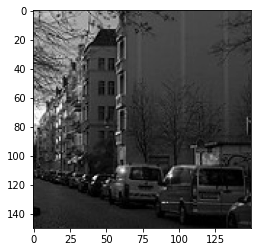

In [ ]:
plt.imshow(data_gray[0].squeeze(dim=0).permute(0, 1), cmap="gray")
plt.show()

In [ ]:
# Train-Validation-Test Split
train_X, validation_X, test_X = data_gray[:4264], data_gray[4264:5685], data_gray[5685:] # 0.6:0.2:0.2
train_y, validation_y, test_y = data_color[:4264], data_color[4264:5685], data_color[5685:] # 0.6:0.2:0.2

# Model & Experiment



## Unet

### Architecture

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels, kernel_size, stride, IsEncoder: bool, padding=0):
        super(CNNBlock,self).__init__()
        if IsEncoder:
            # LeakyReLu for encoder
            act = nn.LeakyReLU(inplace=True)
        else:
            # ReLu for decoder
            act = nn.ReLU()
        # CNN Block: 2D Conv + batch normalization + Nonlinear Activation
        self.Seqblock = nn.Sequential(
            # 2D conv
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            # Batch Normalization
            nn.BatchNorm2d(out_channels),
            # Activation function
            act
        )
    def forward(self, x):
        x = self.Seqblock(x)
        return x 

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channels, padding, downhill=5):
    super().__init__()
    self.enc_layers = nn.ModuleList()
    self.layer_in_channels = in_channels
    self.layer_out_channels = 64
    for _ in range(downhill-2):
      self.enc_layers += [
          CNNBlock(in_channels=self.layer_in_channels, out_channels=self.layer_out_channels, 
                   kernel_size=2, stride=1, IsEncoder=True),
          nn.MaxPool2d(2, 2, padding=1)
          ]
      self.layer_in_channels = self.layer_out_channels
      self.layer_out_channels *= 2
    
    self.layer_out_channels //= 2
    self.enc_layers += [
            CNNBlock(in_channels=self.layer_in_channels, out_channels=self.layer_out_channels, 
                     kernel_size=2, stride=1, IsEncoder=True),
            nn.MaxPool2d(2, 2, padding=1),
            CNNBlock(in_channels=self.layer_in_channels,out_channels=self.layer_out_channels, 
                     kernel_size=2, stride=1, IsEncoder=True)
            ]
  
  def forward(self, x):
    route_connection = []
    for layer in self.enc_layers:
      if isinstance(layer, CNNBlock):
          x = layer(x)
          route_connection.append(x)
      else:
          x = layer(x)
    return x, route_connection 

class Decoder(nn.Module):
  def __init__(self, exit_channels, padding, uphill=5):
    super().__init__()
    self.exit_channels = exit_channels
    self.layer_in_channels = 64*2**(uphill-3)
    self.layer_out_channels = 64*2**(uphill-3)
    self.layers = nn.ModuleList()
    
    self.layers += [
        # Conv 2d_transpose for upsizing
        nn.ConvTranspose2d(self.layer_in_channels, self.layer_in_channels, kernel_size=2, stride=2),
        CNNBlock(in_channels=self.layer_in_channels*2, out_channels=self.layer_in_channels, 
                 kernel_size=2, stride=1, IsEncoder=False),
        ]
    
    for i in range(uphill-2):
        self.layers += [
            # Conv 2d_transpose for upsizing
            nn.ConvTranspose2d(self.layer_in_channels, self.layer_out_channels, kernel_size=2, stride=2),
            CNNBlock(in_channels=self.layer_out_channels*2, out_channels=self.layer_out_channels, 
                     kernel_size=2, stride=1, IsEncoder=False),
            ]
        self.layer_in_channels = self.layer_out_channels
        self.layer_out_channels //= 2
    
    self.layers.append(
        nn.ConvTranspose2d(self.layer_in_channels, self.exit_channels, kernel_size=3, stride=1)
        )

  def forward(self, x, route_connection):
    # pop the last element of the list since it's not used for concatenation
    route_connection.pop(-1)
    for layer in self.layers:
        if isinstance(layer, CNNBlock):
            # center_cropping the route tensor to make width and height match
            x = torchvision.transforms.functional.center_crop(x, route_connection[-1].shape[2])
            # concatenating tensors channel-wise
            x = torch.cat([x, route_connection.pop(-1)], dim=1)
            x = layer(x)
        else:
            x = layer(x)
    return x

class EncoderDecoder(nn.Module):
  def __init__(self, encoder_in_channels, exit_channels, layer_num, padding=1):
      super().__init__()
      self.encoder = Encoder(encoder_in_channels, padding=padding, downhill=layer_num)
      self.decoder = Decoder(exit_channels, padding=padding, uphill=layer_num)


  def forward(self, x):
    enc_out, route_connection = self.encoder(x)
    dec_out = self.decoder(enc_out, route_connection)
    return dec_out

### Training

In [ ]:
def model_train(train_x, train_y, validation_X, validation_y, model, optimizer, loss_fn, batch_size, epoch_num):
    train_dataset = TensorDataset(train_X, train_y)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size)
    num_batches   = len(train_loader)
    
    model.train()
    
    train_l = 0
    train_loss = []
    test_loss  = []
    
    for epoch in range(epoch_num):
        for _, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            train_l += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        if (epoch+1) % 20 == 0:
            loss, current = loss.item(), epoch+1
            print(f"loss: {loss:>7f}  [{current:>5d}/{100}]")
            
        train_loss.append(train_l/num_batches)
        test_loss.append(model_valid(validation_X, validation_y, model, batch_size))
    return train_loss,test_loss

In [ ]:
def model_valid(validation_X, validation_y, net, batch_size):
    
    valid_dataset = TensorDataset(validation_X, validation_y)
    valid_loader  = DataLoader(valid_dataset, batch_size=batch_size)
    
    size_test   = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for X,y in valid_loader:
            X = X.to(device)
            y = y.to(device)
            pred = net(X)
            test_loss += loss_fn(pred,y).item()  
    test_loss /= num_batches

    return test_loss

### Experiments

In [ ]:
if __name__ == '__main__':
  	use_cuda = True if torch.cuda.is_available() else False
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 20
    epoch_num  = 100
    loss_fn = nn.MSELoss()
    if use_cuda:
      model.cuda()
      loss_fn.cuda()
    model = EncoderDecoder(1, 64, 3, 6)
    optimizer = optim.Adam(model.parameters(), lr=0.00009)
    adam_trainLoss,adam_testLoss = model_train(train_X, train_y, validation_X, validation_y, model, 
                                optimizer, loss_fn, batch_size, epoch_num)
    

### Performance

In [ ]:
y_pred = model(test_X)
images  = [y_pred[i].cpu() for i in range(5)]
grid_img = torchvision.utils.make_grid(images, nrow=1)
plt.figure(figsize=(20,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Save Model

In [ ]:
torch.save(model.state_dict(), "path")
# model.load_state_dict(torch.load("path"))
# model.eval()

## Normal GAN (Performance Not Good)

### Architecture

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels, uphill=4):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layer_in_channels = in_channels
    self.layer_out_channels = 64
    for _ in range(uphill):
      self.layers += [
          CNNBlock(in_channels=self.layer_in_channels, out_channels=self.layer_out_channels, 
                  kernel_size=2, stride=2, padding=1, IsEncoder=True),
          ]
      self.layer_in_channels = self.layer_out_channels
      self.layer_out_channels *= 2
    self.layers += [
        nn.Flatten(),
        nn.Linear(121*self.layer_in_channels, 1),
        nn.Sigmoid()
    ]

  def forward(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

### Training

In [ ]:
from torch.autograd import Variable
def model_train(train_X, train_y, validation_X, validation_y, generator, discriminator, optimizer_g, optimizer_d, loss_fn, batch_size, epoch_num):
    train_dataset = TensorDataset(train_X, train_y)
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    generator = generator.to(device=device)
    discriminator = discriminator.to(device=device)
    generator.train()
    discriminator.train()
    valid_loss_g = []
    valid_loss_d = []
    valid_mae = []
    for epoch in range(epoch_num):
        for _, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            # ground truth label 
            valid = Variable(Tensor(X.size(0), 1).fill_(0.0), requires_grad=False)
            fake  = Variable(Tensor(X.size(0), 1).fill_(1.0), requires_grad=False)
            
            X         = Variable(X.type(Tensor)).cuda()
            real_y    = Variable(y.type(Tensor)).cuda()
            real_imgs = torch.cat([X,real_y],dim=1)
            
            # ------------GENERATOR----------------
            optimizer_g.zero_grad()
            pred_g   = generator(X)
            gen_imgs = torch.cat([X.detach(),pred_g],dim=1)

            gan_loss = loss_fn(discriminator(gen_imgs), valid)
            loss_g   = gan_loss + 100*torch.mean(torch.abs(y-pred_g))

            loss_g.backward()
            optimizer_g.step()
            # ------------DISCRIMINATOR----------------
            optimizer_d.zero_grad()
            
            real_loss = loss_fn(discriminator(real_imgs), valid+0.1*torch.randn(valid.size()).cuda())
            fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake+0.1*torch.randn(fake.size()).cuda())            
            loss_d = (real_loss + fake_loss)/2           
            loss_d.backward()
            optimizer_d.step()

        if (epoch+1)% 1 == 0:
            gan_loss,loss_g, loss_d, current = gan_loss.item(),loss_g.item(), loss_d.item(), epoch+1
            print(f"G loss_GAN: {gan_loss:>7f};Total loss_G: {loss_g:>7f}; loss_D: {loss_d:>7f} [{current:>5d}/{100}]")
        loss_G, loss_D,mae_batch = model_valid(validation_X, validation_y, generator, discriminator, loss_fn, batch_size)
        valid_loss_g.append(loss_G)
        valid_loss_d.append(loss_D)
        valid_mae.append(mae_batch)
    return valid_loss_g, valid_loss_d,valid_mae

In [ ]:
def model_valid(validation_X, validation_y, generator, discriminator, loss_fn, batch_size):
  use_cuda = True if torch.cuda.is_available() else False
  device = torch.device("cuda" if use_cuda else "cpu")
  valid_dataset = TensorDataset(validation_X, validation_y)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
  batch_num = len(valid_loader)

  generator.eval()
  discriminator.eval()
  loss_g = 0
  loss_d = 0
  MAE    = 0
  with torch.no_grad():
    for data in valid_loader:
      X, y = data
      X = X.to(device)
      y = y.to(device)

      valid = Variable(Tensor(X.size(0), 1).fill_(0.0), requires_grad=False).cuda()
      fake  = Variable(Tensor(X.size(0), 1).fill_(1.0), requires_grad=False).cuda()

      X         = Variable(X.type(Tensor)).cuda()
      real_y    = Variable(y.type(Tensor)).cuda()
      real_imgs = torch.cat([X,real_y],dim=1)
      
      pred_g   = generator(X)
      gen_imgs = torch.cat([X.detach(),pred_g],dim=1)

      loss_g += (loss_fn(discriminator(gen_imgs), valid)+ 100*torch.mean(torch.abs(y-pred_g))).item()
      
      real_loss = loss_fn(discriminator(real_imgs), valid+0.1*torch.randn(valid.size()).cuda())
      fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake+0.1*torch.randn(fake.size()).cuda())
      
      loss_d += (real_loss + fake_loss)/2

      MAE += torch.mean(torch.abs(y-pred_g)).item()
    loss_g /= batch_num
    loss_d /= batch_num
    MAE /= batch_num

  return loss_g, loss_d, MAE

### Experiments

In [ ]:
if __name__ == '__main__':
	use_cuda = True if torch.cuda.is_available() else False
	device = torch.device("cuda" if use_cuda else "cpu")
	# model train (model test function can be called directly in model_train)
	batch_size = 20
	epoch_num  = 100
	loss_fn = torch.nn.BCELoss()
	generator = EncoderDecoder(1, 3, 6)
	discriminator = Discriminator(4, 4)
	if use_cuda:
		generator.cuda()
		discriminator.cuda()
		loss_fn.cuda()

	optimizer_g = optim.Adam(generator.parameters(), lr=0.00009)
	optimizer_d = optim.Adam(discriminator.parameters(),lr=0.00005)
	Tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
	valid_loss_g, valid_loss_d, valid_mae = model_train(train_X, train_y, validation_X, validation_y, generator, discriminator, optimizer_g, optimizer_d, loss_fn, batch_size, epoch_num)
	print("Generator Loss:", valid_loss_g)
	print("Discriminator Loss:", valid_loss_d)

### Performance

In [ ]:
y_pred = generator(test_X)
images  = [y_pred[i].cpu() for i in range(5)]
grid_img = torchvision.utils.make_grid(images, nrow=1)
plt.figure(figsize=(20,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Save Model

In [ ]:
torch.save(generator.state_dict(), "path")
torch.save(discriminator.state_dict(), "path")
# generator.load_state_dict(torch.load("path"))
# generator.eval()

## Patch GAN

### Architecture

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels, uphill=4):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layer_in_channels = in_channels
    self.layer_out_channels = 64
    for _ in range(uphill-1):
      self.layers += [
          CNNBlock(in_channels=self.layer_in_channels, out_channels=self.layer_out_channels, 
                  kernel_size=2, stride=2, padding=1, IsEncoder=True),
          ]
      self.layer_in_channels = self.layer_out_channels
      self.layer_out_channels *= 2
    self.layer_out_channels //= 2
    self.layers += [
          CNNBlock(in_channels=self.layer_in_channels, out_channels=1, 
                  kernel_size=2, stride=2, padding=1, IsEncoder=True),
          nn.Sigmoid()
          ]

  def forward(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

### Training

In [ ]:
from torch.autograd import Variable
def model_train(train_X, train_y, validation_X, validation_y, generator, discriminator, optimizer_g, optimizer_d, loss_fn, l1_loss, batch_size, lam, epoch_num):
    train_dataset = TensorDataset(train_X, train_y)
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    generator = generator.to(device=device)
    discriminator = discriminator.to(device=device)
    generator.train()
    discriminator.train()
    valid_loss_g = []
    valid_loss_d = []
    valid_mae = []
    for epoch in range(epoch_num):
        for _, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # ground truth label 
            valid = Variable(torch.ones(X.size(0), 1, 11, 11).cuda())
            fake  = Variable(torch.zeros(X.size(0), 1, 11, 11).cuda())
            
            # randomly flip label
            ind_1 = np.random.choice(valid.size(0), 1)
            ind_2 = np.random.choice(valid.size(0), 1)
            valid[ind_1] = torch.zeros(1,11,11).cuda()
            fake[ind_2] = torch.ones(1,11,11).cuda()

            # ------------GENERATOR----------------
            X         = Variable(X.type(Tensor)).cuda()
            real_y    = Variable(y.type(Tensor)).cuda()
            real_imgs = torch.cat([X,real_y],dim=1)

            optimizer_g.zero_grad()
            pred_g   = generator(X)
            gen_imgs = torch.cat([X.detach(),pred_g],dim=1).cuda()

            output_d_f = discriminator(gen_imgs)
            gan_loss = loss_fn(output_d_f, valid)
            loss_second = l1_loss(pred_g, real_y)
            loss_g = gan_loss + lam * loss_second

            loss_g.backward()
            optimizer_g.step()

            # ------------DISCRIMINATOR----------------
            optimizer_d.zero_grad()

            real_loss = loss_fn(discriminator(real_imgs), valid+0.1*torch.randn(valid.size()).cuda())
            fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake+0.1*torch.randn(valid.size()).cuda())
            
            loss_d = (real_loss + fake_loss)/2
            loss_d.backward()
            optimizer_d.step()

        if (epoch+1)% 1 == 0:
            gan_loss,loss_g, loss_d, current = gan_loss.item(),loss_g.item(), loss_d.item(), epoch+1
            print(f"G loss_GAN: {gan_loss:>7f};Total loss_G: {loss_g:>7f}; loss_D: {loss_d:>7f} [{current:>5d}/{200}]")
        loss_G, loss_D, MAE = model_valid(validation_X, validation_y, generator, discriminator, loss_fn, l1_loss, lam, batch_size)
        valid_loss_g.append(loss_G)
        valid_loss_d.append(loss_D)
        valid_mae.append(MAE)
    return valid_loss_g, valid_loss_d, valid_mae

In [ ]:
def model_valid(validation_X, validation_y, generator, discriminator, loss_fn, l1_loss, lam, batch_size):
  #device = torch.device("cuda" if use_cuda else "cpu")
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  valid_dataset = TensorDataset(validation_X, validation_y)
  valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
  batch_num = len(valid_loader)

  generator.eval()
  discriminator.eval()
  loss_g = 0
  loss_d = 0
  MAE    = 0
  with torch.no_grad():
    for data in valid_loader:
      X, y = data
      X = X.to(device)
      y = y.to(device)

      valid = Variable(torch.ones(X.size(0), 1, 11, 11).cuda())
      fake  = Variable(torch.zeros(X.size(0), 1, 11, 11).cuda())

      X         = Variable(X.type(Tensor)).cuda()
      real_y    = Variable(y.type(Tensor)).cuda()
      real_imgs = torch.cat([X,real_y],dim=1)

      pred_g   = generator(X)
      gen_imgs = torch.cat([X.detach(),pred_g],dim=1)
      loss_second = l1_loss(pred_g, real_y)
      loss_g += (loss_fn(discriminator(gen_imgs), valid)+ lam*loss_second).item()
      
      real_loss = loss_fn(discriminator(real_imgs), valid+0.1*torch.randn(valid.size()).cuda())
      fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake+0.1*torch.randn(valid.size()).cuda())
      
      loss_d += (real_loss + fake_loss)/2
      MAE += torch.mean(torch.abs(y-pred_g)).item()
    loss_g /= batch_num
    loss_d /= batch_num
    MAE /= batch_num

  return loss_g, loss_d, MAE

### Experiments

In [ ]:
if __name__ == '__malamin__':
  use_cuda = True if torch.cuda.is_available() else False
  device = torch.device("cuda" if use_cuda else "cpu")
  # model train (model test function can be called directly in model_train)
  lam = 100
  batch_size = 20
  epoch_num  = 100
  loss_fn   = torch.nn.BCELoss()
  l1_loss   = nn.L1Loss()
  generator = EncoderDecoder(1, 3, 6)
  discriminator = Discriminator(4, 4)
  if use_cuda:
    generator.cuda()
    discriminator.cuda()
    loss_fn.cuda()
    l1_loss.cuda()

  optimizer_g = optim.Adam(generator.parameters(), lr=0.00009)
  optimizer_d = optim.Adam(discriminator.parameters(),lr=0.00009,betas=(0.5, 0.999))
  Tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
  valid_loss_g, valid_loss_d, valid_mae = model_train(train_X, train_y, validation_X, validation_y, generator, discriminator, optimizer_g, optimizer_d, loss_fn, l1_loss, batch_size, lam, epoch_num)
  print("Generator Loss:", valid_loss_g)
  print("Discriminator Loss:", valid_loss_d)

### Performance

In [ ]:
y_pred = generator(test_X)
images  = [y_pred[i].cpu() for i in range(5)]
grid_img = torchvision.utils.make_grid(images, nrow=1)
plt.figure(figsize=(20,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Save Model

In [ ]:
torch.save(generator.state_dict(), "path")
torch.save(discriminator.state_dict(), "path")
# generator.load_state_dict(torch.load("path"))
# generator.eval()